# Step1: Creating Second Quantistion Hamiltonian
Example: $Al\ (Z=13)$ Atom

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from pyscf import ao2mo, fci, gto, mcscf, scf, tools
from qiskit.quantum_info import SparsePauliOp


def cholesky(V, eps):
    # see https://arxiv.org/pdf/1711.02242.pdf section B2
    # see https://arxiv.org/abs/1808.02625
    # see https://arxiv.org/abs/2104.08957
    no = V.shape[0]
    chmax, ng = 20 * no, 0
    W = V.reshape(no**2, no**2)
    L = np.zeros((no**2, chmax))
    Dmax = np.diagonal(W).copy()
    nu_max = np.argmax(Dmax)
    vmax = Dmax[nu_max]
    while vmax > eps:
        L[:, ng] = W[:, nu_max]
        if ng > 0:
            L[:, ng] -= np.dot(L[:, 0:ng], (L.T)[0:ng, nu_max])
        L[:, ng] /= np.sqrt(vmax)
        Dmax[: no**2] -= L[: no**2, ng] ** 2
        ng += 1
        nu_max = np.argmax(Dmax)
        vmax = Dmax[nu_max]
    L = L[:, :ng].reshape((no, no, ng))
    print(
        "accuracy of Cholesky decomposition ",
        np.abs(np.einsum("prg,qsg->prqs", L, L) - V).max(),
    )
    return L, ng


def identity(n):
    return SparsePauliOp.from_list([("I" * n, 1)])


def creators_destructors(n, mapping="jordan_wigner"):
    c_list = []
    if mapping == "jordan_wigner":
        for p in range(n):
            if p == 0:
                l, r = "I" * (n - 1), ""
            elif p == n - 1:
                l, r = "", "Z" * (n - 1)
            else:
                l, r = "I" * (n - p - 1), "Z" * p
            cp = SparsePauliOp.from_list([(l + "X" + r, 0.5), (l + "Y" + r, -0.5j)])
            c_list.append(cp)
    else:
        raise ValueError("Unsupported mapping.")
    d_list = [cp.adjoint() for cp in c_list]
    return c_list, d_list


def build_hamiltonian(ecore: float, h1e: np.ndarray, h2e: np.ndarray) -> SparsePauliOp:
    ncas, _ = h1e.shape

    C, D = creators_destructors(2 * ncas, mapping="jordan_wigner")
    Exc = []
    for p in range(ncas):
        Excp = [C[p] @ D[p] + C[ncas + p] @ D[ncas + p]]
        for r in range(p + 1, ncas):
            Excp.append(
                C[p] @ D[r]
                + C[ncas + p] @ D[ncas + r]
                + C[r] @ D[p]
                + C[ncas + r] @ D[ncas + p]
            )
        Exc.append(Excp)

    # low-rank decomposition of the Hamiltonian
    Lop, ng = cholesky(h2e, 1e-6)
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)

    H = ecore * identity(2 * ncas)
    # one-body term
    for p in range(ncas):
        for r in range(p, ncas):
            H += t1e[p, r] * Exc[p][r - p]
    # two-body term
    for g in range(ng):
        Lg = 0 * identity(2 * ncas)
        for p in range(ncas):
            for r in range(p, ncas):
                Lg += Lop[p, r, g] * Exc[p][r - p]
        H += 0.5 * Lg @ Lg

    return H.chop().simplify()

at symmetry=False is a "brute-force" way that works, but it's extremely inefficient.

The point of symmetry=True is twofold: massive computational speedup and correct orbital selection.

he mcscf.sort_mo_by_irrep function would fail completely, because there are no irreps to sort by.

No need for cas_space_symmetry because symmetry doesnt exist anymore

In [23]:
mol = gto.Mole() # gto = gaussian type orbital
mol.build(
    atom=[
        ["Al", (0, 0, 0)]
    ],
    basis="sto-6g",
    spin=1,             # IMPORTANT
    charge=0,
    symmetry=False, # Important
)
print(mol.groupname)
print(mol.irrep_name)


C1
None


RHF is a method that finds an approximate ground state energy by assuming electrons are independent and move in an average field (a single Slater determinant).

In [24]:
mf = scf.RHF(mol) # Setting up Restricted Hartree-Fock Calculation
E1 = mf.kernel() # Runs RHF calculation
print(f"Grounf state energy by RHF = {E1} Hartree = {E1*27.2114} eV")
mf.analyze()


converged SCF energy = -240.813264334633
Grounf state energy by RHF = -240.81326433463306 Hartree = -6552.866061115435 eV
**** MO energy ****
                Roothaan           | alpha              | beta
MO #1   energy= -58.225722190421   | -58.231098082219   | -58.220346298623   occ= 2
MO #2   energy= -4.51220376841594  | -4.52126904994576  | -4.50313848688611  occ= 2
MO #3   energy= -2.74391382396893  | -2.77922439468512  | -2.70860325249385  occ= 2
MO #4   energy= -2.74113831518475  | -2.74470087364254  | -2.73757575672696  occ= 2
MO #5   energy= -2.74113831518475  | -2.74470087364254  | -2.73757575672696  occ= 2
MO #6   energy= -0.222276363820886 | -0.270067494162906 | -0.174485233478867 occ= 2
MO #7   energy= 0.254921877502672  | 0.0218384076299515 | 0.488005346616495  occ= 1
MO #8   energy= 0.423569165055158  | 0.410637564667767  | 0.436500765442549  occ= 0
MO #9   energy= 0.423569165055159  | 0.410637564667768  | 0.43650076544255   occ= 0
 ** Mulliken atomic charges  **
charge 

((array([2.00000000e+00, 2.00000000e+00, 2.00000000e+00, 1.99839027e+00,
         1.99839198e+00, 1.99934678e+00, 1.64478377e-03, 3.42232524e-03,
         9.98803860e-01]),
  array([1.77635684e-15])),
 array([0., 0., 0.]))

## nelecas (Number of active electrons)
 nelecas = number of active electrons = usually total number of valence electrons

 format = (num_spin_up, num_spin_down)
 For a standard calculation (singlet, spin=0), these are just (TotalActive / 2, TotalActive / 2).

for $H_2$ (1,1)

## ncas (Number of Active Orbitals)
 ncas must be large enough to hold all the active electrons

 ### Strategy 1: Full Valence Active Space (FVAS)
 This is the most common and robust starting point.
 
 Rule: Include all molecular orbitals (MOs) that are formed from the valence atomic orbitals (AOs).

 ### Strategy 2: Minimal "Interesting" Space
 For quantum computing (VQE), FVAS is often too large. You want the smallest possible space that captures the physics.
 
 Rule: Pick only the orbitals directly involved in a process.

 LiH example used ncas=5! This means the person who wrote it chose a larger space, likely the $\sigma$, $\sigma^*$, and the 3 p-orbitals from the Li atom, to get a more accurate result. This was a chemical choice.

## cas_space_symmetry (The Practical Tool)
This argument is just a tool to select the ncas orbitals you chose in the previous step. It's more reliable than just picking by energy because orbital energies can be in the "wrong" order.
run mf.analyze() to get the orbitals for cas_space_symmetry


In [25]:
nelecas = (2,1)
ncas = 4
cas_space_symmetry = {'s+0': 1, 'p-1':1, 'p+0':1, 'p+1':1}
mx = mcscf.CASCI(mf, ncas = ncas, nelecas=nelecas)
# mo = mcscf.sort_mo_by_irrep(mx, mf.mo_coeff, cas_space_symmetry)

E2 = mx.kernel(mo)[:2] # second value is active_space_energy
h1e, ecore = mx.get_h1eff()
h2e = ao2mo.restore(1, mx.get_h2eff(), mx.ncas)

print(f"Grounf state energy by RHF = {E1} Hartree = {E1*27.2114} eV")
print(f"Energy levels = {E2[0]} Hartree = {E2[0]*27.2114} eV")

CASCI E = -240.838836789693  E(CI) = -1.63336495264736  S^2 = 0.7500000


Grounf state energy by RHF = -240.81326433463306 Hartree = -6552.866061115435 eV
Energy levels = -240.83883678969298 Hartree = -6553.561923419052 eV


In [26]:
H = build_hamiltonian(ecore, h1e, h2e)

accuracy of Cholesky decomposition  1.1102230246251565e-16


# VQE


In [27]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp

print(H.num_qubits)


8


9


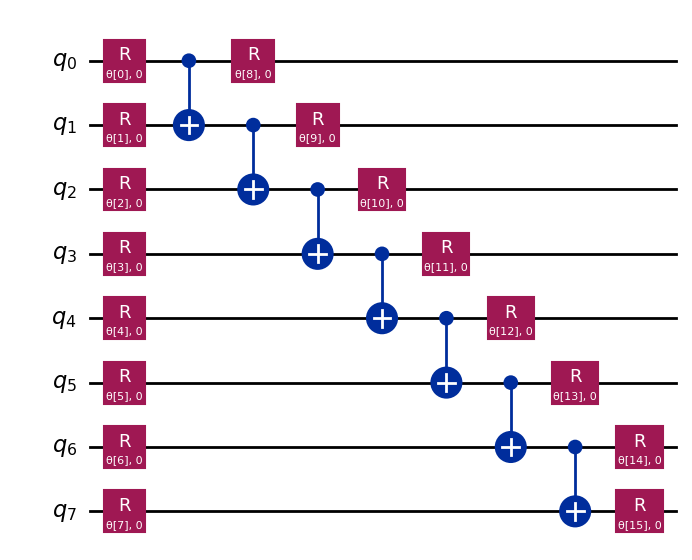

In [28]:
# Pre-defined ansatz circuit
from qiskit.circuit.library import efficient_su2
from scipy.optimize import minimize
# Random initial state and efficient_su2 ansatz
ansatz = efficient_su2(H.num_qubits, su2_gates=["rx"], entanglement="linear", reps=1)
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
print(ansatz.decompose().depth())
ansatz.decompose().draw("mpl")


In [29]:
def cost_func(params, ansatz, H, estimator):
    pub = (ansatz, [H], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    return energy
   

In [30]:
 
# We will start by using a local simulator
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendEstimatorV2

backend = AerSimulator()
estimator = BackendEstimatorV2(backend = backend)


In [31]:

res = minimize(
    cost_func,
    x0,
    args=(ansatz, H, estimator),
    method="cobyla",
    options={"maxiter": 100, "disp": True},
)


Return from COBYLA because the objective function has been evaluated MAXFUN times.
Number of function values = 100   Least value of F = -240.28299965299934
The corresponding X is:
[6.16489863 3.25911095 3.17070969 3.2004156  5.88277273 6.46739
 0.19732163 5.48885152 1.29312843 1.61664008 1.41600076 3.00997786
 4.73160914 6.14851245 3.5680634  3.54166528]



In [32]:

print(getattr(res, "fun"), "Hartree")
print(res)
E3 = getattr(res, "fun")
print(f"Ground State Energy by VQE = {E3} Hartree = {E3*27.114} eV")
print(f"Ground state energy by RHF = {E1} Hartree = {E1*27.2114} eV")
print(f"Ground State Energy level CASCI = {E2[0]} Hartree = {E2[0]*27.2114} eV")

-240.28299965299934 Hartree
 message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
 success: False
  status: 3
     fun: -240.28299965299934
       x: [ 6.165e+00  3.259e+00 ...  3.568e+00  3.542e+00]
    nfev: 100
   maxcv: 0.0
Ground State Energy by VQE = -240.28299965299934 Hartree = -6515.033252591425 eV
Ground state energy by RHF = -240.81326433463306 Hartree = -6552.866061115435 eV
Ground State Energy level CASCI = -240.83883678969298 Hartree = -6553.561923419052 eV
